In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [2]:
#接下来主要是分析数据，进行特征工程，获取可靠的特征
train=pd.read_csv('train.csv')#读取数据
test=pd.read_csv('test.csv')#读取数据

#存储游客的ID,便于访问
PassengerId=test['PassengerId']
train.head(3)    #查看前三行数据

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data=[train,test]#是一个列表，列表里面两个dataframe

In [4]:
full_data.head(5)#full_data不是dataframe

AttributeError: 'list' object has no attribute 'head'

In [5]:
type(full_data)

list

In [6]:
full_data[:5]

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 5              6         0       3   
 6              7         0       1   
 7              8         0       3   
 8              9         1       3   
 9             10         1       2   
 10            11         1       3   
 11            12         1       1   
 12            13         0       3   
 13            14         0       3   
 14            15         0       3   
 15            16         1       2   
 16            17         0       3   
 17            18         1       2   
 18            19         0       3   
 19            20         1       3   
 20            21         0       2   
 21            22         1       2   
 22            23         1       3   
 23            24         1       1   
 24            25        

In [7]:
#添加一些作者自己的特征
#1，顾客name的长度
#直接增加一个属性列；直接对整个属性列进行操作；apply(function)中的函数对整体操作
train['Name_length']=train['Name'].apply(len)

In [8]:
test['Name_length']=train['Name'].apply(len)

In [9]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51


In [10]:
#2，是否有客舱号码Cabin也是一个特征，有就为1，没有就为0
train['Has_Cabin']=train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin']=test['Cabin'].apply(lambda x : 0 if type(x)==float else 1)

In [11]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,23,0


In [12]:
#下面是这个选手Sina的特征选择过程
#新特征1 家庭人数的数量FamilySize，就是SibSp+Parch+自己的总和
for dataset in full_data:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

In [13]:
test.head(0)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize


In [14]:
#新特征2：IsAlone是否是一个人的旅途，也就是FamilySize是1
for dataset in full_data:
    dataset['IsAlone']=0
    dataset.loc[dataset['FamilySize']==1,'IsAlone']=1

In [15]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1


In [16]:
for dataset in full_data:
    dataset['Embarked']=dataset['Embarked'].fillna('S')

In [17]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,1,2,0


In [18]:
train['Fare'].head(10)

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
5     8.4583
6    51.8625
7    21.0750
8    11.1333
9    30.0708
Name: Fare, dtype: float64

In [19]:
train['Fare'].median()

14.4542

In [20]:
#把数据集的Fare票价这一列中为0 的填充为该列的median()中位数
for dataset in full_data:
    dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

In [21]:
#新特征3： 加一个新特征CategoricalFare
train['CategoricalFare']=pd.qcut(train['Fare'],4)

In [22]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"[0, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,1,2,0,"(31, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]"


In [23]:
train["Age"].isnull().sum()

177

In [24]:
#测试
np.random.randint(1,10,2)

array([5, 1])

In [25]:
#新特征4：添加一个新特征CategoricalAge
for dataset in full_data:
    age_avg=dataset['Age'].mean()#平均值
    age_std=dataset['Age'].std()#标准差
    age_null_count=dataset['Age'].isnull().sum()#年龄为空的个数
    age_null_random_list=np.random.randint(age_avg-age_std,age_avg+age_std,size=age_null_count)#随机一个列表，赋给为空的值
    dataset['Age'][np.isnan(dataset['Age'])]=age_null_random_list#把为空的取出来，再把随机的列表与之对应
    dataset['Age']=dataset['Age'].astype(int)#转换类型

In [26]:
train['CategoricalAge']=pd.qcut(train['Age'],5)

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"[0, 7.91]","(19, 25]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31, 512.329]","(32, 40]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]","(25, 32]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,44,1,2,0,"(31, 512.329]","(32, 40]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]","(32, 40]"


In [28]:
#定义一个函数，获取Name中的称呼，比如Mrs,Mr等，符合 Mr. 这样的形式
def get_title(name):
    title_search=re.search(' ([A-Za-z]+\.)',name)
    #如果有title的话返回，没有则返回''
    if title_search:
        return title_search.group(1)
    return ''

In [29]:
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [30]:
train.head(2
          )

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"[0, 7.91]","(19, 25]",Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31, 512.329]","(32, 40]",Mrs.


In [31]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [32]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"[0, 7.91]","(19, 25]",Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31, 512.329]","(32, 40]",Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]","(25, 32]",Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,44,1,2,0,"(31, 512.329]","(32, 40]",Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]","(32, 40]",Mr.


In [33]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr.": 1, "Miss.": 2, "Mrs.": 3, "Master.": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [34]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"[0, 7.91]","(19, 25]",1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31, 512.329]","(32, 40]",3.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]","(25, 32]",2.0


In [39]:
for dataset in full_data:
    dataset['Title']=dataset['Title'].astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [40]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"[0, 7.91]","(19, 25]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31, 512.329]","(32, 40]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.91, 14.454]","(25, 32]",2


In [41]:
#现在需要的特征基本完了，现在需要把一些无用的特征属性给去掉，删除掉
drop_elements=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train=train.drop(drop_elements,axis=1)#去掉列表中的属性列
train=train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)#只删除train中这两个列，因为test没有添加，
                                                                 #这两个列其实只是为了划分一个区间出来，便于mapping到整数上去
test=test.drop(drop_elements,axis=1)


In [42]:
# All right so now having cleaned the features and extracted relevant information and dropped the categorical columns
# our features should now all be numeric, a format suitable to feed into our Machine Learning models.
# However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho
# 数据已清洗，特征已确定
# 下面做一些数据相关性和数据分布的展示

In [44]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [45]:
# Pearson Correlation Heatmap

# let us generate some correlation plots of the features to see how related one feature is to the next. 
# To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows
#皮尔逊相关系数热图，利用seaborn画图模块  import seaborn as sns

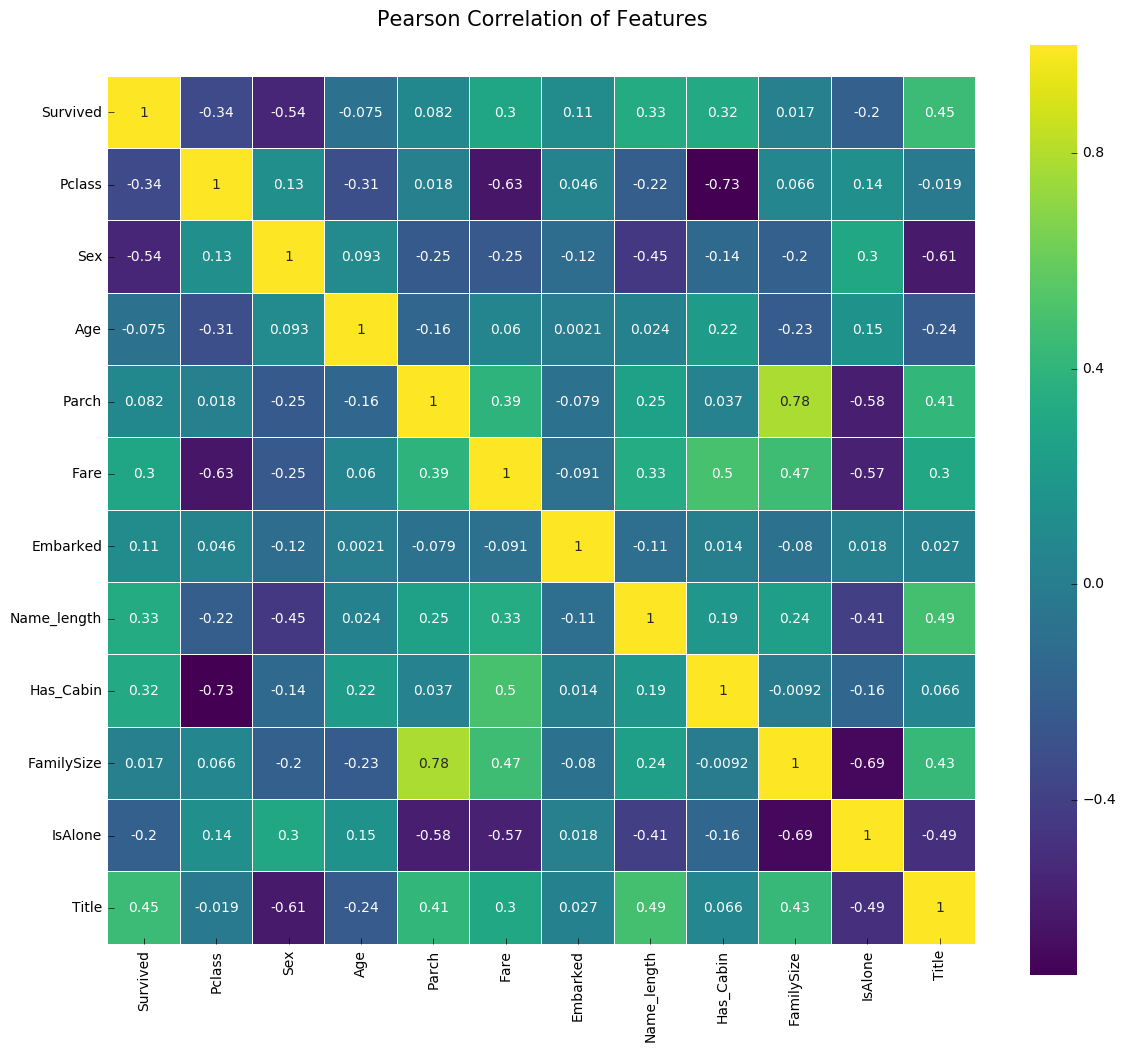

In [46]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [47]:
#从上图可以看出，就和矩阵一样，指定行与指定列对应的值，表示这两个特征的相关性。可以看出只有familySize和Parch的颜色比较偏黄，说明其相关性较大
#其实可以合为一个特征，但是作者还是保留了....

TypeError: slice indices must be integers or None or have an __index__ method

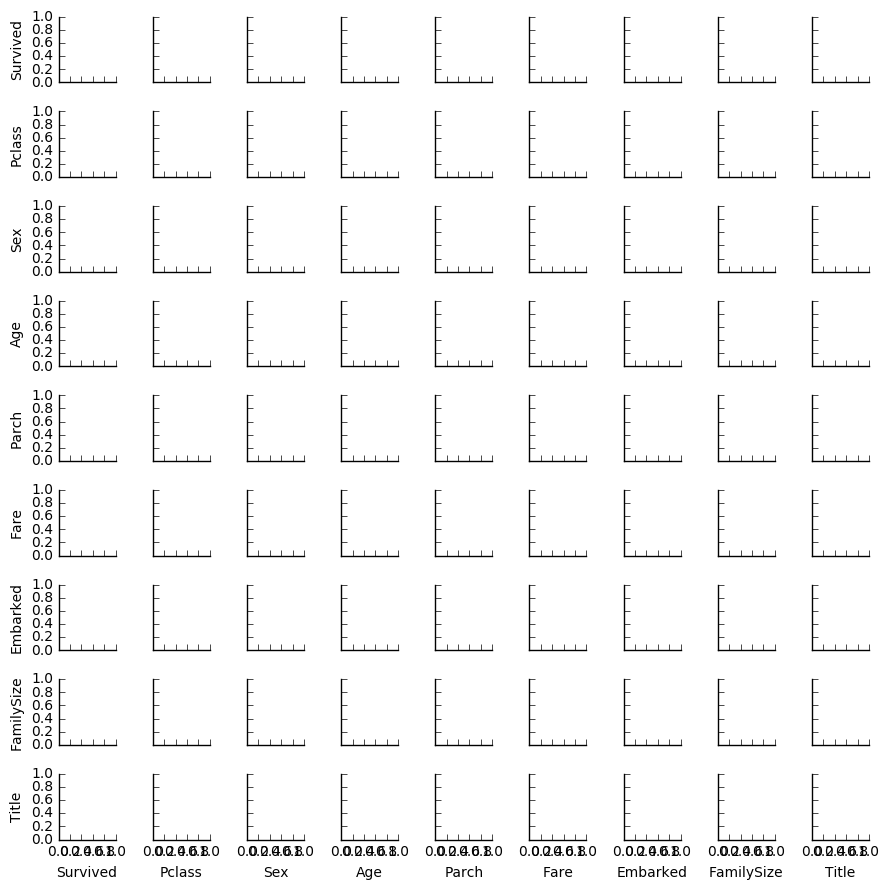

In [52]:
#下面再看一下多变量图pairplot,反应特征与特征之间的关系，以及是否存活在每个特征上的分布


g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [51]:
train.head(10)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,2,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3


In [53]:
#这个pairplot图不知道为什么会报错，百度了也找不到具体原因，对此不怎么熟悉

In [54]:
#Ensembling & Stacking models
#直接开始集成的学习

In [57]:
#先定义一些可以用到的参数
ntrain=train.shape[0]#891
ntest=test.shape[0]#418
SEED=0#为了可以重复试验，以便在试验的时候可以随机出相同的训练集和测试集
NFOLDS=5#5折交叉
kf=KFold(ntrain,n_folds=NFOLDS,random_state=SEED)


In [58]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [59]:
#这个函数是用于交叉实验的
#clf是选择的分类模型，x_train是所有训练集，y_train是所有训练集样本的类别标签，x_test是给定的所有测试集
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))#长度为891的全0array
    oof_test = np.zeros((ntest,))#长度为418的全0array
    oof_test_skf = np.empty((NFOLDS, ntest))#一个用随机值填充的5*418的矩阵，用来存放5次交叉后的预测结果

    for i, (train_index, test_index) in enumerate(kf):
        #5次交叉，5次循环
        #kf实际上是一个迭代器，是从891个样本中分成了5组训练集和测试集的索引号
        x_tr = x_train[train_index]#当前循环，当前实验的训练数据
        y_tr = y_train[train_index]#当前循环的训练数据标签
        x_te = x_train[test_index]#d当前循环的测试数据

        clf.train(x_tr, y_tr)#用模型去拟合数据，也就是训练预测模型

        oof_train[test_index] = clf.predict(x_te)#把测试数据的预测标签按照对应索引，放到oof_train对应索引处
        oof_test_skf[i, :] = clf.predict(x_test)#用当前的模型，预测所有测试数据的标签，并放到oof_test_skf的一行中

        
    #5次实验做完，把5次得到的结果求平均
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [60]:
#先产生第一层的基础模型，并给出常用的模型参数

# Generating our Base First-Level Models
# So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

# Random Forest classifier
# Extra Trees classifier
# AdaBoost classifer
# Gradient Boosting classifer
# Support Vector Machine
# Parameters

# Just a quick summary of the parameters that we will be listing here for completeness,

# n_jobs : Number of cores used for the training process. If set to -1, all cores are used.

# n_estimators : Number of classification trees in your learning model ( set to 10 per default)

# max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

# verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

# Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

In [61]:
# Put in our parameters for said classifiers
# Random Forest parameters随机森林
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters极端树，随机森林的一个变种，具体还没有看算法原理
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [62]:
#得到五个模型
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [63]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()#将标签列转换为array
train = train.drop(['Survived'], axis=1)#删除标签列
x_train = train.values # Creates an array of the train data#得到训练数据的值，转换成array形式了，去掉了表头
x_test = test.values # Creats an array of the test data

In [64]:
x_train.head(3)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [65]:
x_train[2]

array([ 3,  0,  1,  0,  1,  0, 22,  0,  1,  1,  2], dtype=int64)

In [66]:
#得到5个模型的5交叉训练与预测结果
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [67]:
# Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, 
# we can now fit a second-level learning model.
#把第一级别的基础模型得到的训练集和测试集的预测结果作为x_train和x_test.
#注意，这里拼接在一起的是预测的标签结果数据，而不是原来的数据
#比如每个结果是891*1的矩阵，5个方法的结果拼在一起就是891*5的数据集，这个则作为第二层模型的训练数据，它的标签还是原始数据的标签
#同理测试数据则为418*5的数据集
et_oof_train

array([[ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
      

In [68]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [69]:
x_train#891*5的数据集

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [70]:
x_test#418*5的测试集

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.2,  0. ],
       [ 1. ,  1. ,  1. ,  0.4,  1. ]])

In [71]:
#这里用xgboost作为第二层的模型
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)#得到预测结果

In [73]:
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [74]:
with open('stackingPredictions.txt','w') as fw:
    for l in predictions:
        fw.write(str(l)+'\n')
        